In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import string
from multiprocessing import Pool


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.inchi import *
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import logging
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import *
from custom_layers import *
from model import *
from plots import *
from evals import *

In [3]:
def get_isomers(inchi):
    m=MolFromInchi(inchi)
    formula = CalcMolFormula(m)
    url = urllib.request.urlopen('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/formula/'+formula+'/property/InChI/txt')
    for i in url:
        if 'ListKey'in str(i):
            listkey = str(i).split(' ')[1].rstrip("'")
        else:
            continue
    
    
    urllib.request.urlopen('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/'+str(listkey)+'/property/InChI/txt')
    urllib.request.urlretrieve('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/'+str(listkey)+'/property/InChI/txt', "temp.txt")
    f = open('temp.txt')
    l = f.readlines()[0].find("InChI")==-1
    f.close()
    while l:
        urllib.request.urlopen('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/'+str(listkey)+'/property/InChI/txt')
        urllib.request.urlretrieve('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/'+str(listkey)+'/property/InChI/txt', "temp.txt")
        f = open('temp.txt')
        l = f.readlines()[0].find("InChI")==-1
        f.close()

In [4]:
def predict_rt_for_isomers_lists(inchi, rt,  pretrained_path):
    print(rt)
    rt=rt.values[0]
    
    p=Pool(8)
    batch_size=64
    ds = pd.read_csv('temp.txt', sep='\t', header=None, names=['inchi'])
    ds['rt_true'] = rt
    #ds['formula'] = formula
    ds['inchi_true'] = inchi
    ds['smiles'] = p.map(inchi2smiles, ds['inchi'])
    ds=ds[ds.smiles!='NA']
    
    
    ds['mol'] = ds['smiles'].apply(molecule_from_smiles)
    ds['graph'] = p.map(graph_from_molecule, ds['mol'])
    
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []
    for g in ds.graph:
        atom_features_list.append(g[0])
        bond_features_list.append(g[1])
        pair_indices_list.append(g[2])
        
    
        
    
    X = (np.array(atom_features_list), np.array(bond_features_list), np.array(pair_indices_list))
    print(X[0].shape)
    X = (tf.ragged.constant(X[0], dtype=tf.float32),
         tf.ragged.constant(X[1], dtype=tf.float32),
         tf.ragged.constant(X[2], dtype=tf.int64))
    
    
    
    y = np.zeros(ds.shape[0])
    
    dataset = tf.data.Dataset.from_tensor_slices((X,(y)))
    dataset = dataset.batch(batch_size).map(prepare_batch, -1)
    
    mpnn = MPNNModel_frozen(atom_dim=X[0][0][0].shape[0], bond_dim=X[1][0][0].shape[0], batch_size=batch_size)
    mpnn.load_weights(pretrained_path)
    
    
    Y = mpnn.predict(dataset)
    ds['rt_pred'] = Y
    
    return ds[['inchi', 'rt_true', 'inchi_true', 'rt_pred']]

In [5]:
def get_df_for_dataset(ds, pretrained_path):
    df = pd.DataFrame()
    for inchi in ds.inchi:
        #while len(pd.read_csv('temp.csv'))
        get_isomers(inchi)
        
        df=df.append(predict_rt_for_isomers_lists(inchi, ds[ds.inchi==inchi].rt,  pretrained_path))
    df['re'] = 100*abs(df['rt_true']-df['rt_pred'])/df['rt_true']
    return df

In [6]:
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in range(len(FPR)-1):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

In [7]:
def ROC(df, threshold):
    TPR=[]
    FPR=[]
    
    df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])
    
    N = len(df[df.pos==False])
    print(P, N)
    for thresh in threshold:
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR.append(TP/P)
        FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    with open('../results/ROC_curves.txt', 'a') as f:
        f.write('Best threshold:'+ str(threshold[np.argmax(np.array(TPR)-np.array(FPR))])+'\n')
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
        

In [8]:
def get_search_space_reduction(df, threshold):
    #df['pos'] = df['inchi']==df['inchi_true']
    df['filtered'] = df['re']>threshold
    total, filtered=[],[]
    for inchi in df[df['pos']==True].inchi:
        new_df = df[df['inchi_true']==inchi]
        total.append(len(new_df))
        filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered
    
        

In [9]:
ds_name='LIFE_old'
with open('../results/ROC_curves.txt', 'a') as f:
    f.write(ds_name+'\n')

In [10]:
threshold=np.arange(0, 200, 2.5)
#put test dataset path here
ds = pd.read_csv('../data/test_LIFE_old.csv', sep=';')

#put pretrained model path here
pretrained_path = '../models/LIFE_old_final/mpnn_LIFE_old_final.h5'
#get joint dataset with isomers
df = get_df_for_dataset(ds, pretrained_path)


0    85.713
Name: rt, dtype: float64


C:\Users\SERGEY~1.OSI\AppData\Local\Temp/ipykernel_12408/2765034707.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = (np.array(atom_features_list), np.array(bond_features_list), np.array(pair_indices_list))


(5093,)
1    114.761
Name: rt, dtype: float64
(391,)
2    46.885
Name: rt, dtype: float64
(1036,)
3    69.531
Name: rt, dtype: float64
(506,)
4    35.108
Name: rt, dtype: float64
(1487,)
5    100.806
Name: rt, dtype: float64
(633,)
6    79.319
Name: rt, dtype: float64
(2538,)
7    52.921
Name: rt, dtype: float64
(419,)
8    36.187
Name: rt, dtype: float64
(321,)
9    105.082
Name: rt, dtype: float64
(6421,)
10    36.016
Name: rt, dtype: float64
(2538,)
11    97.791
Name: rt, dtype: float64
(35712,)
12    39.68
Name: rt, dtype: float64
(2015,)
13    106.82
Name: rt, dtype: float64
(462,)
14    86.785
Name: rt, dtype: float64
(1117,)
15    39.429
Name: rt, dtype: float64
(1915,)
16    182.698
Name: rt, dtype: float64
(3416,)
17    97.142
Name: rt, dtype: float64
(1117,)
18    101.128
Name: rt, dtype: float64
(1080,)
19    33.654
Name: rt, dtype: float64
(1050,)
20    184.401
Name: rt, dtype: float64
(329,)
21    80.76
Name: rt, dtype: float64
(1836,)
22    111.582
Name: rt, dtype: float6

In [11]:
#Get arrays of TPR, FPR and best threshold values
TPR, FPR, thresh = ROC(df, threshold)
#Get ROC AUC
AUC  = ROC_AUC(TPR, FPR)
with open('../results/ROC_curves.txt', 'a') as f:
        f.write('AUC = '+ str(AUC)+'\n')
print('AUC = ', AUC)
print(thresh)
total, filtered = get_search_space_reduction(df, thresh)



49 108645
Best threshold: 20.0
AUC =  0.7568170440894842
20.0


In [12]:
relative = [100*x/y for x,y in zip(filtered,total)]
with open('../results/ROC_curves.txt', 'a') as f:
        f.write('Average number of eliminated false identities'+str(100-np.mean(relative))+'\n')
        f.write('Average number of eliminated false identities'+str(100-np.median(relative))+'\n')
print('Average number of eliminated false identities', 100-np.mean(relative))
print('Median number of eliminated false identities', 100-np.median(relative))

Average number of eliminated false identities 30.806735164140918
Median number of eliminated false identities 31.844288449266116


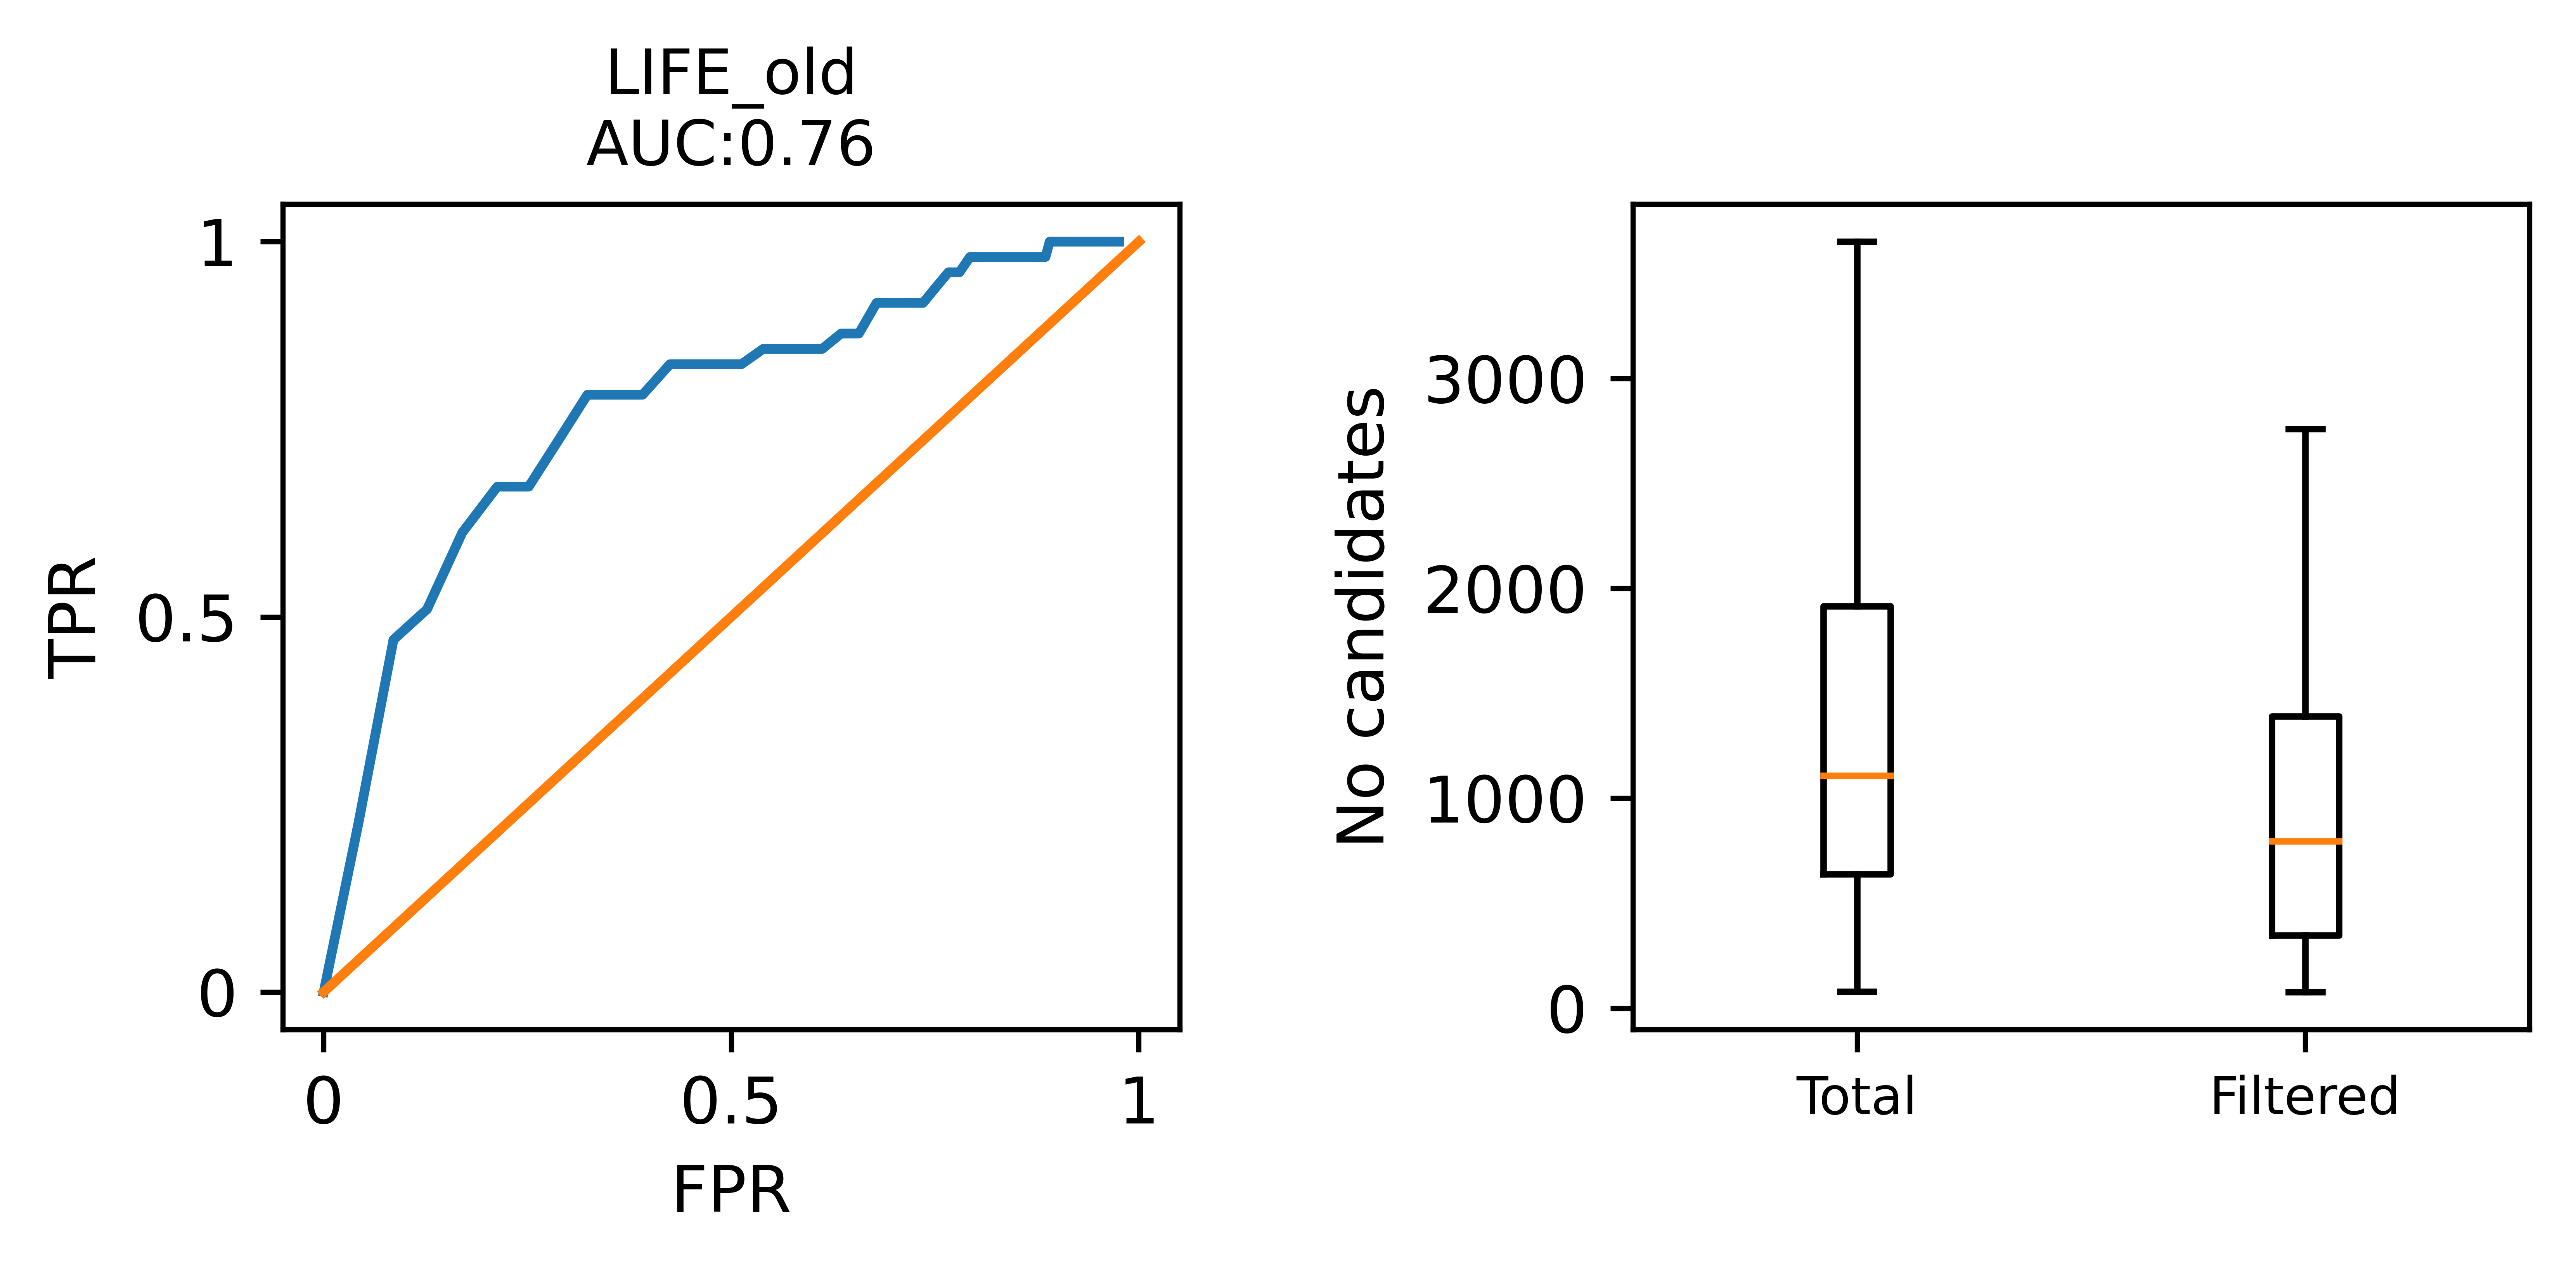

In [13]:
import matplotlib
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(6, 3.2), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 8})
for ds in [ds_name]:   
    #print(st.mean(RF[ds]))
    axs[0].plot(FPR, TPR)
    axs[0].plot(x,y)
    axs[0].set_yticks([0,0.5, 1])
    axs[0].set_xticks([0,0.5, 1])
    axs[0].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[0].set_yticklabels(['0', '0.5', '1'])
    axs[0].set_xticklabels(['0', '0.5', '1'])
    axs[0].set_title(ds+'\n'+'AUC:'+'%.2f'%(AUC))
    
    
    
    axs[1].boxplot((total, filtered), showfliers=False)
    axs[1].set_xticklabels(labels, fontsize=8)
    axs[1].set_ylabel('No candidates')
    fig.tight_layout(pad=3.0)
    fig.savefig('../figs/ROC_'+ds_name+'.svg')